In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import time
from scipy.stats import f

In this simulation, the post-change variance is given by $\sigma^2_2 = 1$, and pre-change variance given by

$$
\frac{\sigma_2^2}{\sigma_1^2} = 1 +  C \left\{ \frac{\log \log(8n)}{\Delta} + \sqrt{\frac{\log \log(8n)}{\Delta}} \right\}
$$


This is an up-to-constants equivalent formulation of the detection boundary... in particular, the regime change now occurrs at $\Delta = \log\log(8n)$ regardless of $C$, which seems more realistic... In the code below, $C$ is called rho_const.


### Defining necessary functions

In [ ]:
@nb.njit(nb.int64[:](nb.int64, nb.int64))
def get_grid(n, min_sample_size):
    grid = 2 ** np.arange(0, int(np.floor(np.log2(n / 2.0))) + 1)
    return grid[grid >= min_sample_size]


def get_nonscaled_pens(n, min_sample_size, alpha=0.05):
    grid = get_grid(n, min_sample_size)
    pens = np.zeros(grid.size)
    for i in range(grid.size):
        t = grid[i]
        q = 1 - alpha / (2 * grid.size)
        pens[i] = f.ppf(q, dfn=t, dfd=t)

    return pens


@nb.njit(nb.float64(nb.float64[:], nb.int64, nb.float64[:]))
def eval_optimal_test_stat(x, min_sample_size, pens):
    n = x.size
    grid = get_grid(n, min_sample_size)

    cumsum = np.cumsum(x**2)
    totcumsum = cumsum[-1]

    maxstat = 0
    for i in range(grid.size):
        t = grid[i]

        var1 = cumsum[t - 1] / t
        var2 = (totcumsum - cumsum[n - t - 1]) / t

        
        if np.abs(var1) < 1e-10 or np.abs(var2) < 1e-10:
            logvar1 = np.log(var1)
            logvar2 = np.log(var2)
            if np.isinf(logvar1) or np.isinf(logvar2):
                continue
            if var1 > var2:
                tmp = (logvar1 - logvar2) - np.log(pens[i])
                if np.exp(tmp) > maxstat:
                    maxstat = np.exp(tmp)
            else:
                tmp = (logvar2 - logvar1) - np.log(pens[i])
                if np.exp(tmp) > maxstat:
                    maxstat = np.exp(tmp)

            continue

        pen = pens[i]

        if var1 > var2:
            tmp = (var1 / var2) / pen
            if tmp > maxstat:
                maxstat = tmp
        else:
            tmp = (var2 / var1) / pen
            if tmp > maxstat:
                maxstat = tmp
    return maxstat


@nb.njit(nb.float64(nb.float64[:], nb.int64))
def eval_LR_test(x, min_sample_size):
    n = x.size

    cumsum = np.cumsum(x**2)
    totcumsum = cumsum[-1]

    maxstat = 0
    for i in range(n - 1):
        t = i + 1  # changepoint location with 1-indexing
        if t < min_sample_size:
            continue
        if t > n - min_sample_size:
            break

        LR = n / 2 * np.log(totcumsum / n)
        LR = LR - t / 2 * np.log(cumsum[t - 1] / t)
        LR = LR - (n - t) / 2 * np.log((totcumsum - cumsum[t - 1]) / (n - t))

        if LR > maxstat:
            maxstat = LR
    return maxstat


@nb.njit(nb.float64(nb.int64, nb.int64, nb.float64, nb.int64, nb.float64[:], nb.int64))
def calibrate_optimal_test_stat(n, K, alpha, min_sample_size, pens, seed):
    maxes = np.zeros(K)
    np.random.seed(seed)
    for i in range(K):
        x = np.random.normal(0, 1, n)
        maxes[i] = eval_optimal_test_stat(x, min_sample_size, pens)

    # get upper alpha quantile
    return np.quantile(maxes, 1 - alpha)


@nb.njit(nb.float64(nb.int64, nb.int64, nb.float64, nb.int64, nb.int64))
def calibrate_LR_test(n, K, alpha, min_sample_size, seed):
    maxes = np.zeros(K)
    np.random.seed(seed)
    for i in range(K):
        x = np.random.normal(0, 1, n)
        maxes[i] = eval_LR_test(x, min_sample_size)

    # get upper alpha quantile
    return np.quantile(maxes, 1 - alpha)


@nb.njit(
    nb.types.Tuple((nb.float64[:], nb.int64, nb.float64))(
        nb.int64, nb.int64, nb.float64, nb.int64
    )
)
def dataset_with_change(n, pos, rho_const, seed):
    np.random.seed(seed)
    delta = pos

    dd = delta

    ratio = 1 + rho_const * (
        np.log(np.log(8 * n)) / dd + np.sqrt(rho_const * np.log(np.log(8 * n)) / dd)
    )
    prevar = 1 / ratio
    postvar = 1
    kappa = postvar - prevar

    x = np.zeros(n)
    x[:delta] = np.random.normal(0, np.sqrt(prevar), delta)
    x[delta:] = np.random.normal(0, np.sqrt(postvar), n - delta)
    return x, delta, kappa


@nb.njit(
    nb.types.Tuple(
        [
            nb.int64[:, :],
            nb.float64[:, :],
            nb.float64[:, :],
            nb.float64[:, :],
            nb.int64[:, :],
            nb.int64[:, :],
            nb.float64[:, :],
        ]
    )(
        nb.int64,
        nb.int64[:],
        nb.int64,
        nb.float64,
        nb.float64,
        nb.float64,
        nb.int64,
        nb.float64[:],
        nb.int64,
    )
)
def simulate_tests(
    n, positions, iter, rho_const, cc, cc_LR, min_sample_size, pens, seed
):
    num_pos = positions.size
    deltas = np.zeros((num_pos, iter), dtype=np.int64)
    kappas = np.zeros((num_pos, iter))
    stat = np.zeros((num_pos, iter))
    stat_LR = np.zeros((num_pos, iter))
    reject = np.zeros((num_pos, iter), dtype=np.int64)
    reject_LR = np.zeros((num_pos, iter), dtype=np.int64)
    snrs = np.zeros((num_pos, iter))

    for i in range(num_pos):
        for j in range(iter):
            pos = positions[i]
            x, delta, kappa = dataset_with_change(
                n=n, pos=pos, rho_const=rho_const, seed=seed + i * iter + j
            )
            deltas[i, j] = delta
            kappas[i, j] = kappa
            stat[i, j] = eval_optimal_test_stat(x, min_sample_size, pens)
            if stat[i, j] > cc:
                reject[i, j] = 1

            snr1 = delta * kappa / (1 - kappa)
            snr2 = delta * kappa**2 / (1 - kappa) ** 2
            if snr1 < snr2:
                snrs[i, j] = snr1
            else:
                snrs[i, j] = snr2

            stat_LR[i, j] = eval_LR_test(x, min_sample_size)
            if stat_LR[i, j] > cc_LR:
                reject_LR[i, j] = 1

    return deltas, kappas, stat, stat_LR, reject, reject_LR, snrs

In [ ]:
n = 5000 # sample size
num_mc = 10_000 # number of monte carlo simulations to choose the thresholds
alpha = 0.05 # significance level
iter = 10_000 # number of iterations in the simulation study
min_sample_size = 1 # smallest distance from the boundary the methods are allowed to consider. smallest possible is 1
seed = 1234
pens = get_nonscaled_pens(n, min_sample_size, alpha)

In [ ]:
critical_val = calibrate_optimal_test_stat(
    n=n, K=num_mc, alpha=alpha, min_sample_size=min_sample_size, pens=pens, seed=1
)
critical_val_LR = calibrate_LR_test(
    n=n, K=num_mc, alpha=alpha, min_sample_size=min_sample_size, seed=1
)

In [5]:
print(critical_val)
print(critical_val_LR)

0.9928841953874935
5.8709259427259255


### C = rho_const = 0.1

In [6]:
rho_const = 0.1

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3553.0272278785706 seconds


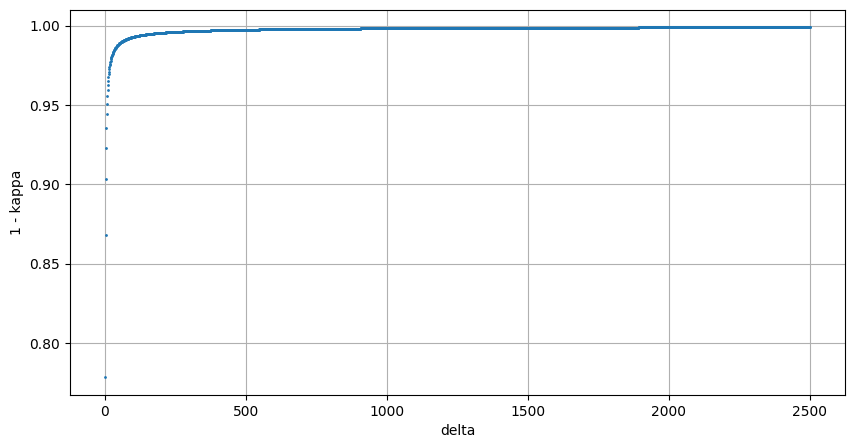

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

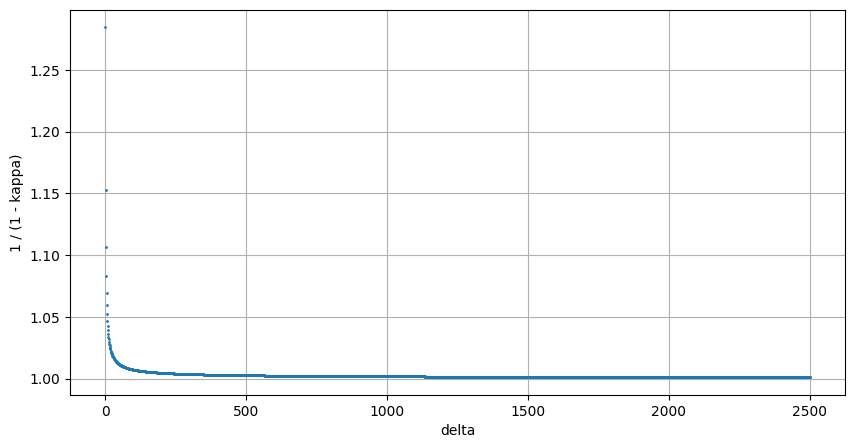

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

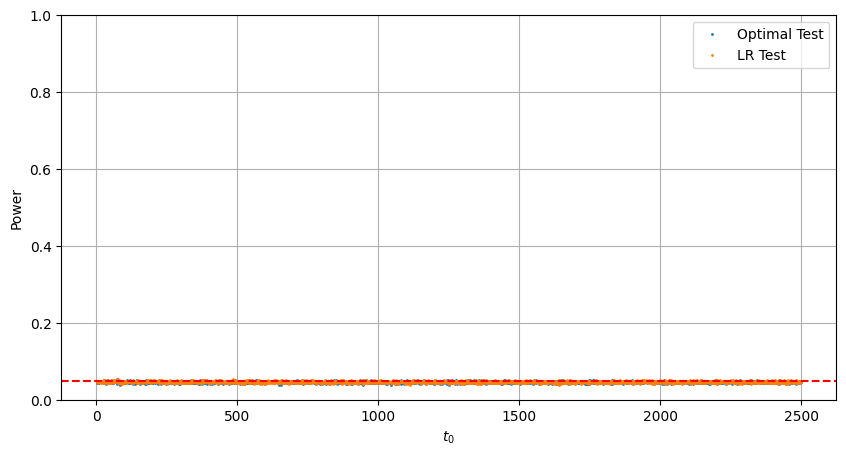

In [10]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [11]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()

### C = rho_const = 1

In [12]:
rho_const = 1

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3557.1764628887177 seconds


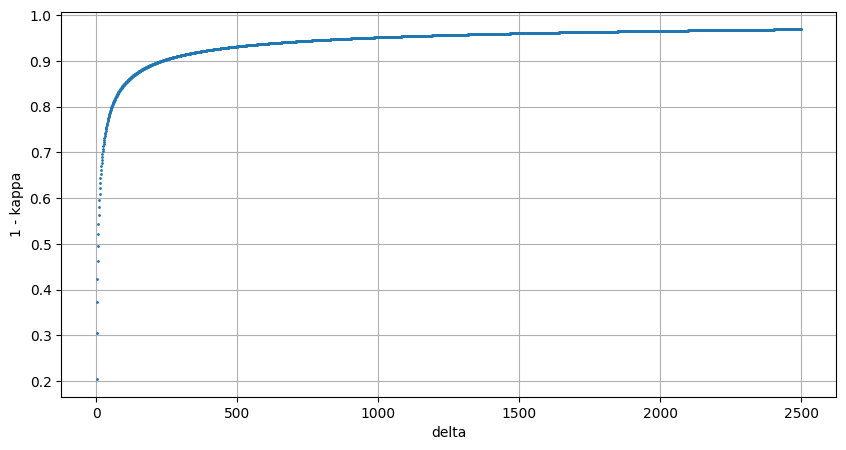

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

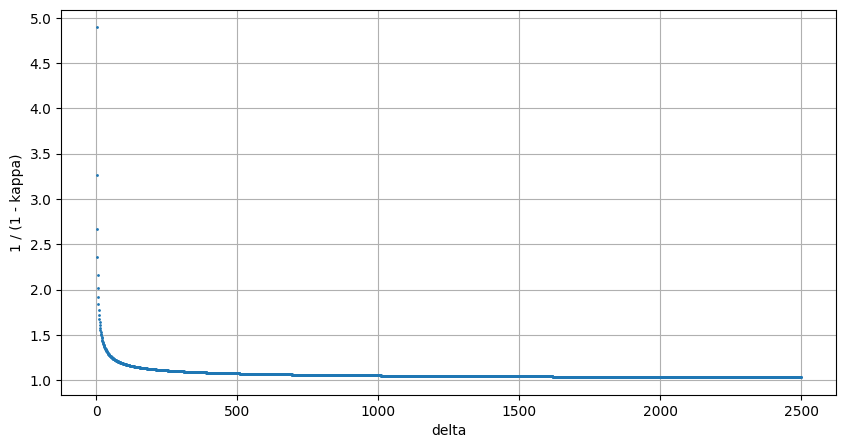

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

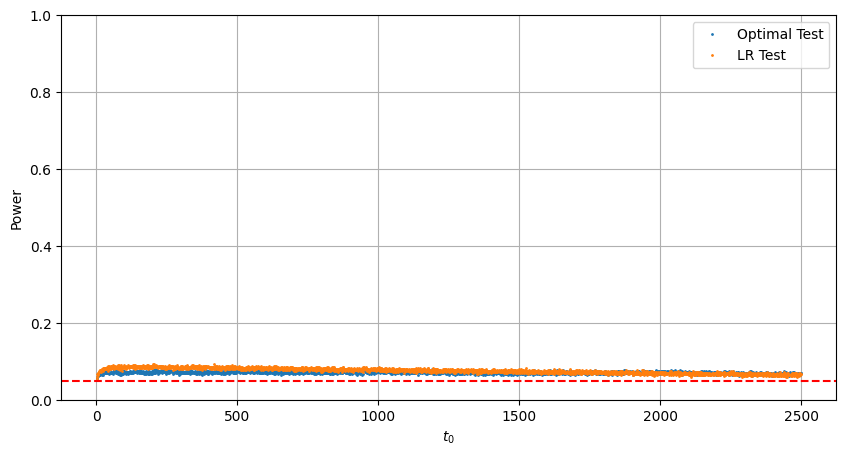

In [16]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [17]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()

### C = rho_const = 5/2

In [18]:
rho_const = 2.5

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3527.359461545944 seconds


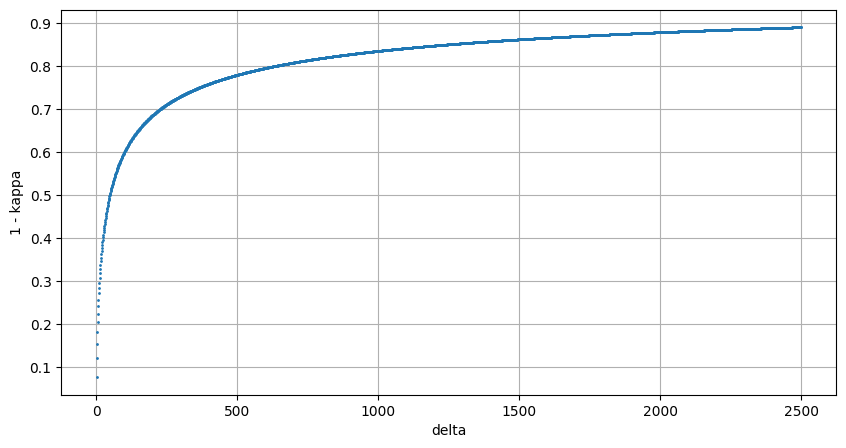

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

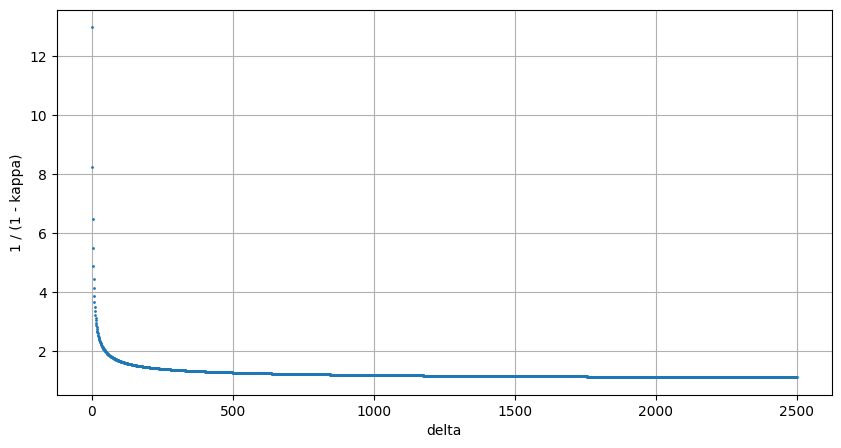

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

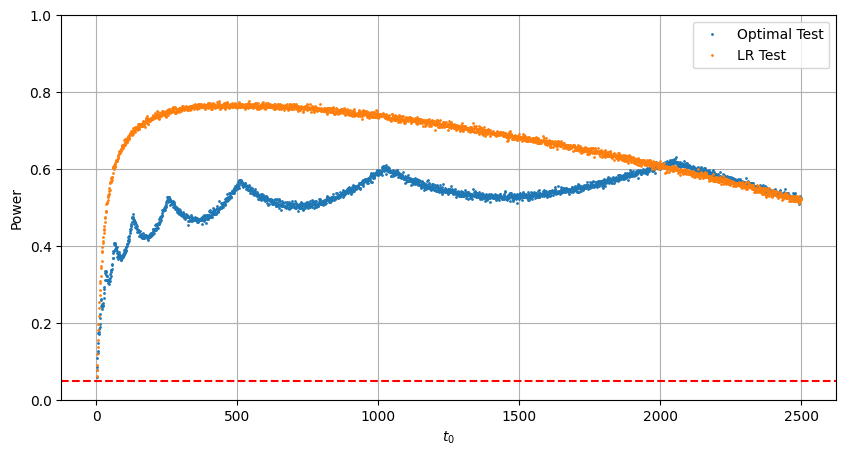

In [22]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [23]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()

### C = rho_const = 5

In [24]:
rho_const = 5

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3554.69473528862 seconds


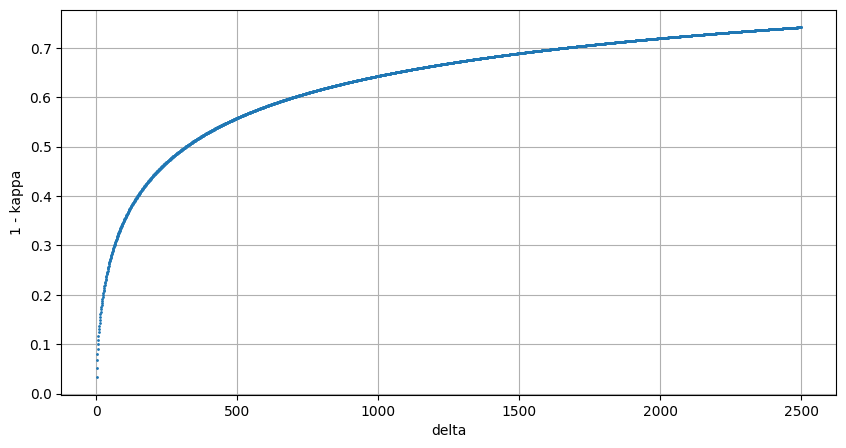

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

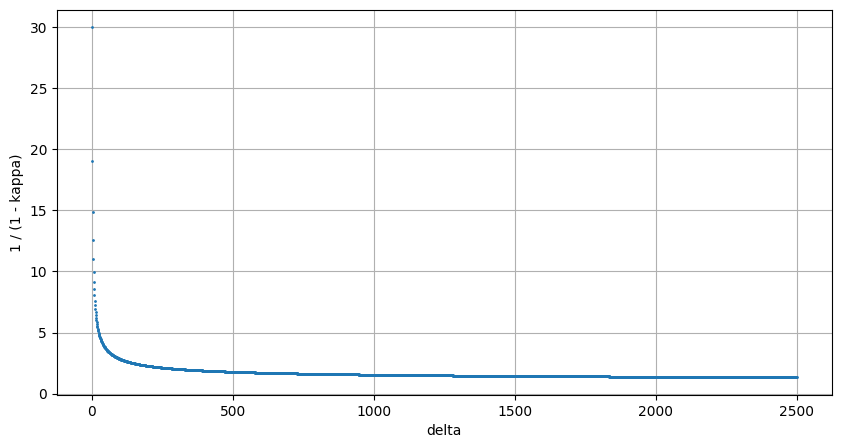

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

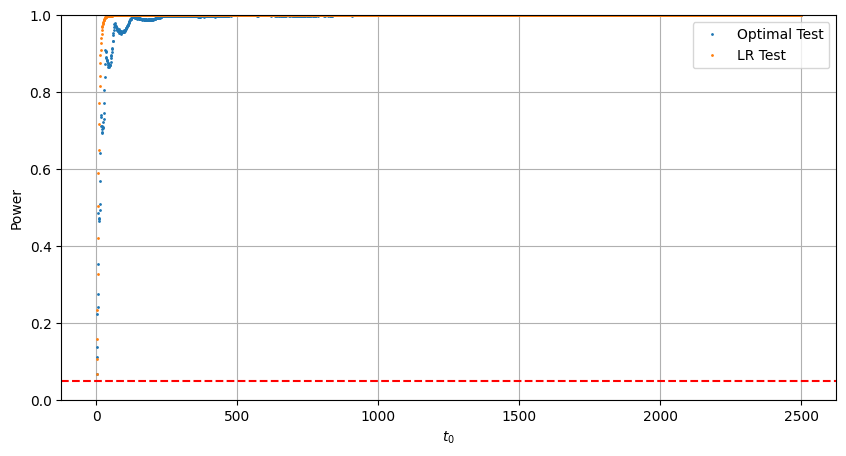

In [28]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [29]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()

### C = rho_const = 100

In [30]:
rho_const = 100

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3521.6308121681213 seconds


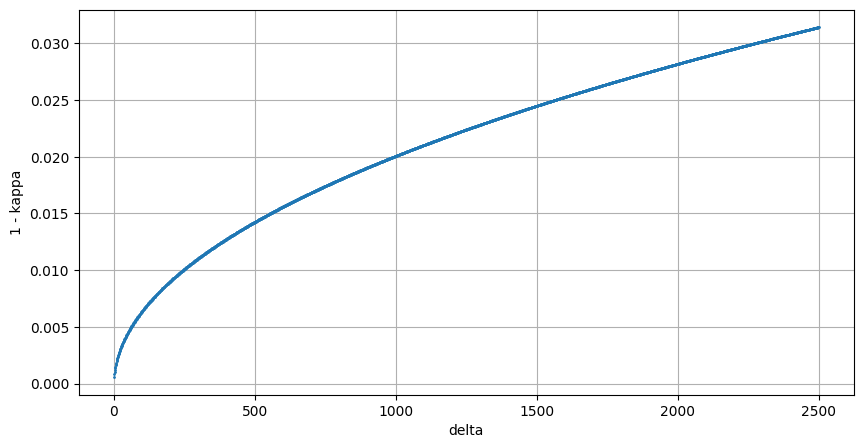

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

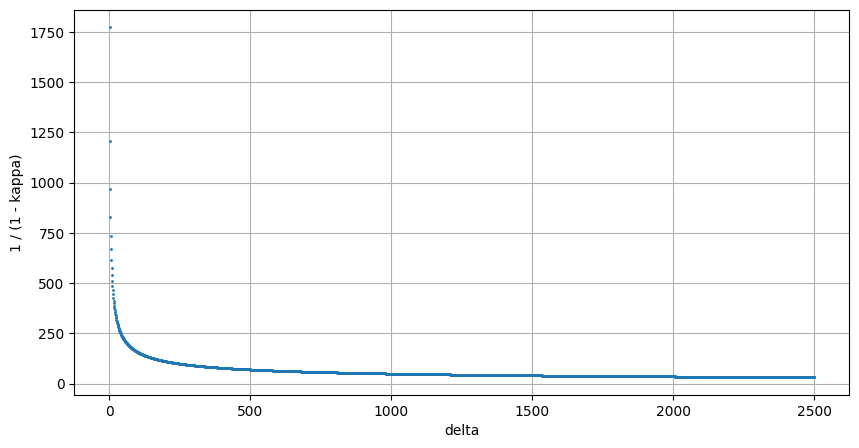

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

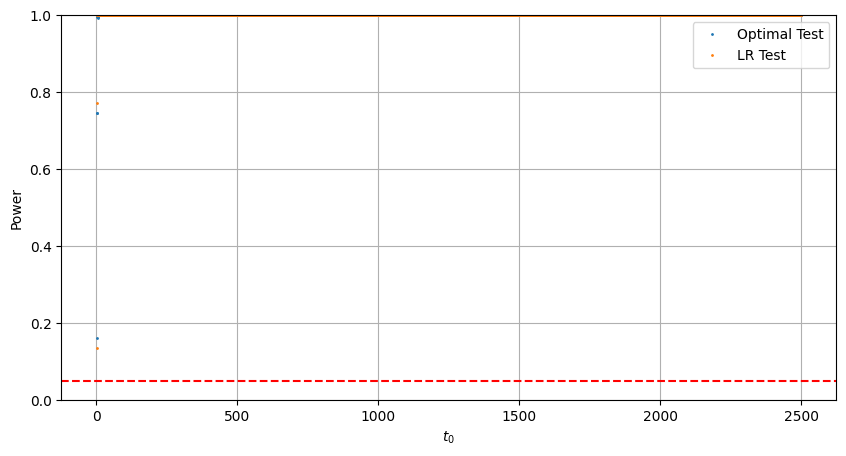

In [34]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [35]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()

### C = rho_const = 1000000

In [36]:
rho_const = 1_000_000

In [ ]:
positions = np.arange(1, n // 2 + 1)

# start timer
start = time.time()

deltas, kappas, stat, stat_LR, reject, reject_LR, snrs = simulate_tests(
    n=n,
    positions=positions,
    iter=iter,
    rho_const=rho_const,
    cc=critical_val,
    cc_LR=critical_val_LR,
    min_sample_size=min_sample_size,
    pens=pens,
    seed=seed,
)
elapsed = time.time() - start

print(f"Time elapsed: {elapsed} seconds")

Time elapsed: 3464.3054320812225 seconds


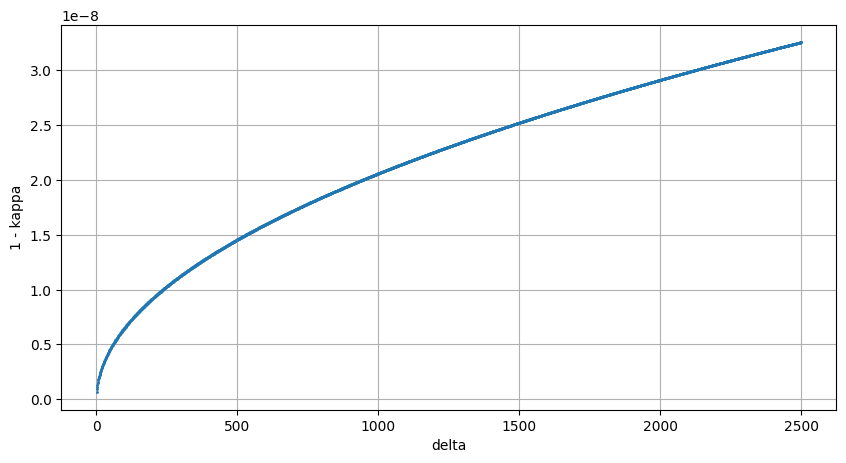

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 - kappas[:, 0], "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 - kappa")
plt.grid()
plt.show()

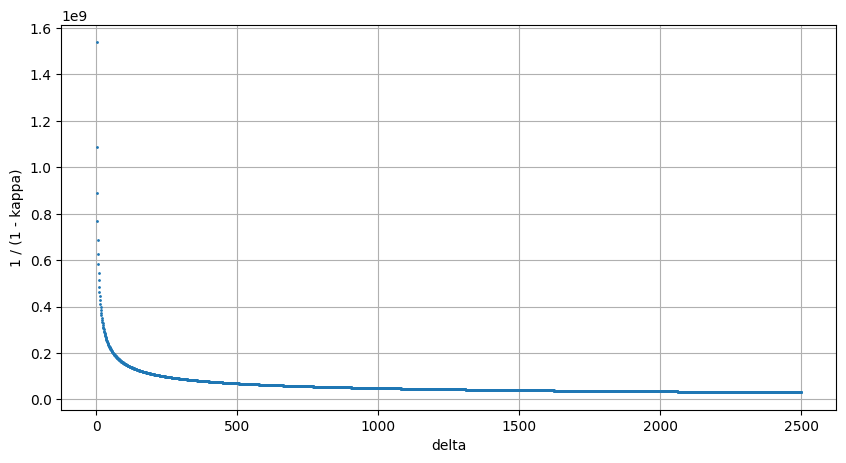

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], 1 / (1 - kappas[:, 0]), "o", markersize=1)
plt.xlabel("delta")
plt.ylabel("1 / (1 - kappa)")
plt.grid()
plt.show()

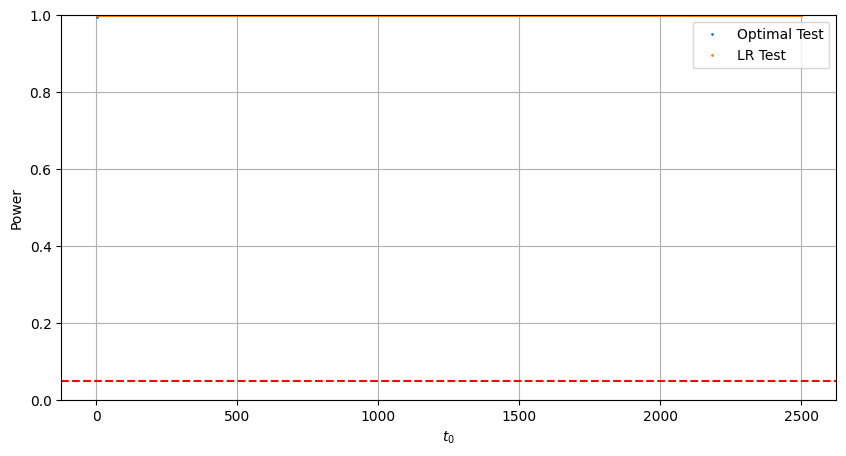

In [40]:
powers = np.mean(reject, axis=1)
powers_LR = np.mean(reject_LR, axis=1)
np.savez(
    f"univariate_rho_const={rho_const}_n={n}",
    deltas=deltas,
    kappas=kappas,
    powers=powers,
    powers_LR=powers_LR,
    snrs=snrs,
)
plt.figure(figsize=(10, 5))
plt.plot(deltas[:, 0], powers, "o", markersize=1)
plt.plot(deltas[:, 0], powers_LR, "o", markersize=1)
plt.xlabel("$t_0$")
plt.ylabel("Power")
plt.grid()
plt.legend(["Optimal Test", "LR Test"])
# add horizontal line for significance level
plt.axhline(y=0.05, color="r", linestyle="--")
# scale y axis to be between 0 and 1
plt.ylim(0, 1)
plt.show()

In [41]:
plt.rcdefaults()
plt.rcParams["text.usetex"] = False  # Explicitly disable LaTeX
plt.rcParams["text.latex.preamble"] = ""  # Clear any LaTeX preamble


# Create figure
plt.figure(figsize=(6.5, 4.5))  # Single-column size (~3.5 inches)

# Plot data
plt.plot(deltas[:, 0], powers, "o", markersize=0.5, color="navy", label="Optimal Test")
plt.plot(
    deltas[:, 0], powers_LR, "o", markersize=0.5, color="darkorange", label="LR Test"
)

# Labels and line
plt.xlabel("$t_0$", fontsize=9)
plt.ylabel("Power", fontsize=9)
plt.axhline(y=0.05, color="red", linestyle="--", label="Significance (0.05)")
plt.ylim(0, 1)

# Legend and grid
plt.legend(fontsize=8, markerscale=8)
plt.grid(True, linestyle="--", alpha=0.5)

# Save as PDF (try PNG if PDF fails)
try:
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.pdf",
        dpi=300,
        bbox_inches="tight",
        format="pdf",
    )
except Exception as e:
    print(f"PDF saving failed: {e}")
    plt.savefig(
        f"power_plot_rho_const={rho_const}_n={n}.png",
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
plt.close()